<div class="alert alert-block alert-info">
<center><h1>TEXT MINING PROJECT</h1></center>
<br>
<center>MDSAA 2021/2022</center>
<center>
Nicola Andreatta (m20211297),
Mariana Ferreira (r20181071),
Farina Pontejos (m20210649), 
Joana Tavares (m2021062)
</center>

**Table of Contents** <br>

* [1) Importing Libraries](#importlibraries)
* [2) Loading Data](#loadingdata)
* [3) Baseline Preprocessing](#preprocessing)
* [4) Data Understanding](#understanding)
* [5) Modelling](#modelling)
    * [5.1) Baseline KNN](#baseknn)
    * [5.2) VotingClassifier](#voting)
* [6) Results](#results)
    * [6.1) Dev Set](#res-dev)
    * [6.2) Test Set](#res-test)


<a class="anchor" id="importlibraries">

# 1. Importing Libraries

</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier

import re

In [2]:
from sklearn import __version__ as sklearn_version
from platform import python_version 
from matplotlib import __version__ as mp_version

print("python version:  ", python_version())
print("nltk version:    ", nltk.__version__)
print("pandas version:  ", pd.__version__)
print("numpy version:   ", np.__version__)
print("sklearn version: ", sklearn_version)
print("matplotlib version:  ", mp_version)


python version:   3.9.7
nltk version:     3.6.7
pandas version:   1.3.3
numpy version:    1.20.3
sklearn version:  1.0.2
matplotlib version:   3.4.3


Package versions used:

```
python version:   3.9.7
nltk version:     3.6.7
pandas version:   1.3.3
numpy version:    1.20.3
sklearn version:  1.0.2
matplotlib version:   3.4.3
```

## Setting Variables

In [3]:
plt.style.use('seaborn-paper')
plt.rcParams['figure.dpi'] = 128

In [4]:
RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)

<a class="anchor" id="loadingdata">

# 2. Loading Data

</a>

In [5]:
url1 = './data/dev_set.txt'
dev_set = pd.read_csv(url1, delimiter='\t')

In [6]:
url2 = './data/training_set.txt'
train_set = pd.read_csv(url2, delimiter='\t')

In [7]:
url3 = './data/test_set.txt'
test_set = pd.read_csv(url3, delimiter='\t')

<a class="anchor" id="preprocessing">

# 3. Preprocessing

</a>

In [8]:
## Uncomment these on first run
#nltk.download('omw-1.4')
#nltk.download('averaged_perceptron_tagger')


In [9]:
stop = text.ENGLISH_STOP_WORDS
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [10]:
def lemmatize_sentences(sentence):
    tokens = sentence.split()
    lemmd_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmd_tokens)

def text_preprocessing(df_, col):
    
    df = df_.copy()
    df['original'] = df[col]
    """
    Baseline preprocessing: 
        - lowercase
        - remove symbols (keep letters, ?, !)
        - remove stop words in pipeline instead of in preprocessing
        - use lemmatizing instead of stemming
    """
    keep = ['?', '!']
    
    ## Lowercase
    df[col] = df[col].str.lower()
    
    ## Remove symbols
    df[col] = df[col].apply(lambda x: ''.join([re.sub(r'[\.;:,\"\'\/]','',x)]))
        
    ## Use Lemmatizer
    df[col] = df[col].apply(lambda x: lemmatize_sentences(x) )
    
    ## Remove excess spaces
    df[col] = df[col].apply(lambda x: re.sub(' +', ' ', x))
    df[col] = df[col].str.strip()
    
    return df

In [11]:
train_set_prep = text_preprocessing(train_set, 'sentence')

In [12]:
dev_set_prep = text_preprocessing(dev_set, 'sentence')

In [13]:
test_set_prep = text_preprocessing(test_set, 'sentence')

<a class="anchor" id="understanding">

# 4. Data Understanding

</a>

In [14]:
labels = {
    1: 'Anger',
    2: 'Anticipation',
    3: 'Digust',
    4: 'Fear',
    5: 'Joy',
    6: 'Sadness',
    7: 'Surprise',
    8: 'Trust',
}

In [15]:
X_train = train_set_prep['sentence']
Y_train = train_set_prep['emotion']

X_dev = dev_set_prep['sentence']
Y_dev = dev_set_prep['emotion']

X_test = test_set_prep['sentence']

<a class="anchor" id="modelling">

# 5. Modelling

</a>

In [16]:
f1labels = ["F1 " + labels[i+1] for i in range(len(labels))]
rclabels = ["Recall " + labels[i+1] for i in range(len(labels))]
pclabels = ["Precision " + labels[i+1] for i in range(len(labels))]
numlabels = [i+1 for i in range(len(labels))]


In [17]:
def get_scores(preds, label, cv_score, truth=Y_dev):
    return pd.DataFrame([[label,
               accuracy_score(truth, preds),
               recall_score(truth, preds, average='macro'),
               precision_score(truth, preds, average='macro'),
               f1_score(truth, preds, average='macro', ),
               cv_score,
               *(f1_score(truth, preds, average=None, labels=numlabels)),
               *(recall_score(truth, preds, average=None, labels=numlabels)),
               *(precision_score(truth, preds, average=None, labels=numlabels)),
            ]],
             columns=["Model", "Accuracy", "Recall", "Precision", "F1", "Train Accuracy", *f1labels, *rclabels, *pclabels ],
             index=[label]
        )
    
def print_scores(preds, gs_, Y=Y_dev):
    
    print("Best parameters: ")
    print(gs_.best_params_)
    print("------------------------")

    print("Accuracy:         ", round(accuracy_score(Y_dev, preds),4))
    print("Macro F1:         ", round(f1_score(Y_dev, preds, average='macro'),4))
    print("Macro Recall:     ", round(recall_score(Y_dev, preds, average='macro'),4))
    print("Macro Precision:  ", round(precision_score(Y_dev, preds, average='macro'),4))
    print("Best Train Score: ", round(gs_.best_score_,4))

    return

def plot_cm(preds, title, Y=Y_dev):
    cm_ = confusion_matrix(Y, preds)
    df_cm = pd.DataFrame(cm_, index=numlabels, columns=numlabels)
    
    fig, ax = plt.subplots(figsize=(7,5))
    
    ax = sns.heatmap(df_cm, annot=True,cmap="Blues", fmt="d")
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")
    
    plt.title("Confusion Matrix: "+title, fontsize=12)
    
    
    plt.show()
    
    return



In [18]:
score_func = 'accuracy'

<a class="anchor" id="baseknn">

## 5.1. Baseline KNN

</a>

In [19]:
pipe_knn = Pipeline([
    ('count', CountVectorizer()),     # CountVectorizer 
    ('classifier', KNeighborsClassifier()),  # 
])

grid_knn = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None],
}

gs_knn = GridSearchCV(pipe_knn, grid_knn, n_jobs=-1, cv=10, scoring=score_func)
gs_knn.fit(X_train, Y_train)
gs_knn_pred = gs_knn.predict(X_dev)


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None}
------------------------
Accuracy:          0.289
Macro F1:          0.2271
Macro Recall:      0.2322
Macro Precision:   0.2582
Best Train Score:  0.269


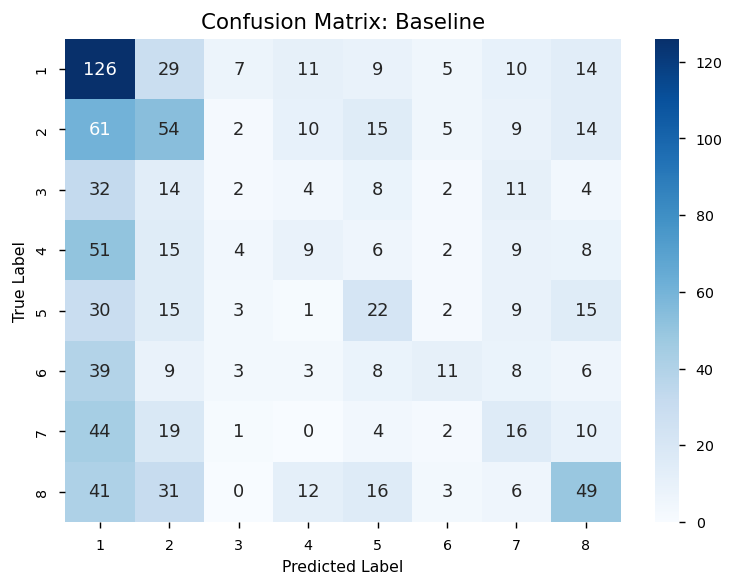

In [20]:
print_scores(gs_knn_pred, gs_knn)
scores = get_scores(gs_knn_pred, "KNN Baseline", gs_knn.best_score_)
plot_cm(gs_knn_pred, "Baseline")

<a class="anchor" id="voting">

## 5.10. Voting Classifier
(Using optimized base estimators)

</a>

In [21]:
vc = VotingClassifier(
    estimators=[('lr', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, solver='lbfgs', multi_class='multinomial')), 
                ('sg', SGDClassifier(random_state=RANDOM_STATE, loss='log')), 
                ('nb', MultinomialNB(alpha=.5)),
                ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE, loss='deviance', n_estimators=200, learning_rate=.25)),
                ('sv', SVC(random_state=RANDOM_STATE, kernel='linear', decision_function_shape='ovo'))
               ],
    voting='hard'
)

vc_pipe = Pipeline([
        ('count', CountVectorizer()),    
        ('vc', vc)
    ])


grid_vc = {
    "count__ngram_range": [(1,1)],
    "count__stop_words": [None]
}

gs_vc = GridSearchCV(vc_pipe, grid_vc, n_jobs=-1, cv=10, scoring=score_func)

gs_vc.fit(X_train, Y_train)
gs_vc_pred = gs_vc.predict(X_dev)



In [22]:
print_scores(gs_vc_pred, gs_vc)
get_scores(gs_vc_pred, "VotingClassifier", gs_vc.best_score_)

scores = pd.concat([scores,get_scores(gs_vc_pred, "VotingClassifier", gs_vc.best_score_)])


Best parameters: 
{'count__ngram_range': (1, 1), 'count__stop_words': None}
------------------------
Accuracy:          0.389
Macro F1:          0.358
Macro Recall:      0.3504
Macro Precision:   0.3868
Best Train Score:  0.3828


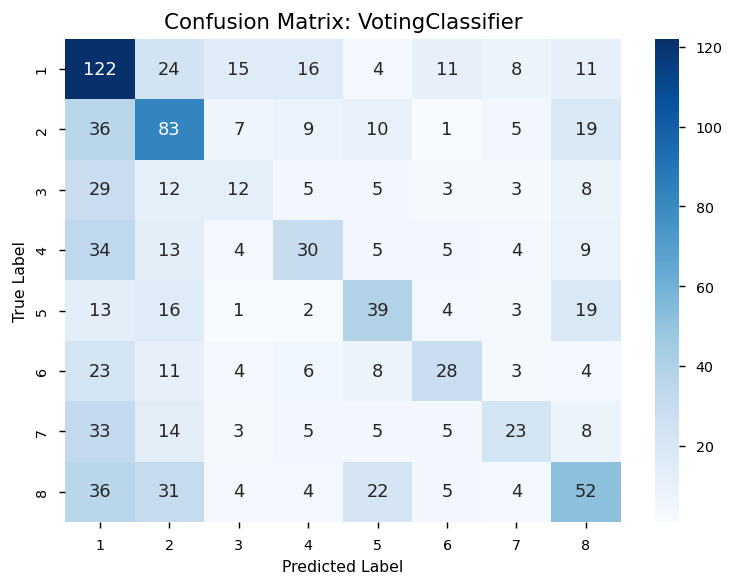

In [23]:
plot_cm(gs_vc_pred, "VotingClassifier")

<a class="anchor" id="results">

# 6. Results

</a>

<a class="anchor" id="res-dev">

# 6.1. Dev Set

</a>

In [24]:
dev_set_results = dev_set_prep[['original']].copy()

In [25]:
dev_set_results

,original
0,What happens to the gold in our safe ?
1,Natural to get cold feet .
2,"Not very lucky , is he ?"
3,I'm just a little anxious to get up there and ...
4,Did you think we don't know about your affair ...
...,...
995,All I ask of you is be careful .
996,"You don't like jazz , pal ?"
997,Put it on .
998,Can you ever imagine [PERSON] being in a spot ...


In [26]:
dev_set_results['emotion'] = gs_vc.predict(dev_set_prep['sentence'])

In [27]:
dev_set_results = dev_set_results.rename(columns={'original':'sentence'})
dev_set_results

,sentence,emotion
0,What happens to the gold in our safe ?,2
1,Natural to get cold feet .,1
2,"Not very lucky , is he ?",5
3,I'm just a little anxious to get up there and ...,1
4,Did you think we don't know about your affair ...,1
...,...,...
995,All I ask of you is be careful .,4
996,"You don't like jazz , pal ?",3
997,Put it on .,1
998,Can you ever imagine [PERSON] being in a spot ...,5


In [28]:
dev_res_url = './dev_results.txt'
dev_set_results.to_csv(dev_res_url, sep='\t', index = False)

<a class="anchor" id="res-test">

# 6.2. Test Set

</a>

In [29]:
test_set_prep['emotion'] = gs_vc.predict(test_set_prep['sentence'])

In [30]:
test_set_results = test_set_prep.drop(columns=['sentence']).rename(columns={'original':'sentence'})

In [31]:
test_res_url = './test_results.txt'
test_set_results.to_csv(test_res_url, sep='\t', index = False)

---

*end*